# Instructions
In `dibecs_3.3.0` run
+ `conda install -c conda-forge python-graphviz`
+ `pip install pydot "pymc3>=3.11" "calibr8>=5.0.3"`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets
import pandas
import pathlib
import numpy
from matplotlib import cm, pyplot

import pymc3
import arviz

import retl
import calibr8
import robotools

import cutisplit
import run_9REA8P


print(f"pymc {pymc3.__version__}")
print(f"calibr8 {calibr8.__version__}")

pymc 3.11.0
calibr8 5.0.3


## Model inputs
The model reproduces the experimental layout and dilutions of samples/standards that go into the assays.
This layout should be given in a `DataFrame`, indexed by the `input_well` ID (the DWP well) and having columns `"type"` and `"concentration_factor"`.

The `"type"` should represent the kind of sample.
`"concentration_factor"` allows you to analyze different dilutions at the same time.

In [3]:
df_inputs = run_9REA8P.get_df_inputs()
df_inputs.head()

,type,concentration_factor
input_well,,
A01,reference,1.0
A02,reference,0.201053
A03,reference,0.041053
A04,reference,1.0
A05,reference,0.201053


We'll need at least one dataset - Cutinase, split-GFP or both.
The cutinase dataset should be represented as a DataFrame:

In [4]:
df_cutinase = run_9REA8P.get_df_cutinase()
df_cutinase.head()

time   value
well cycle                  
A01  1      0.000000  0.5716
     2      1.359850  0.6470
     3      2.719533  0.7318
     4      4.079183  0.8188
     5      5.438900  0.9021

To translate between absorbance readings and product concentration, the model needs a `calibr8` calibration model for p-Nitrophenol absorbance/concentration.
This calibration model was fitted in a separate notebook.

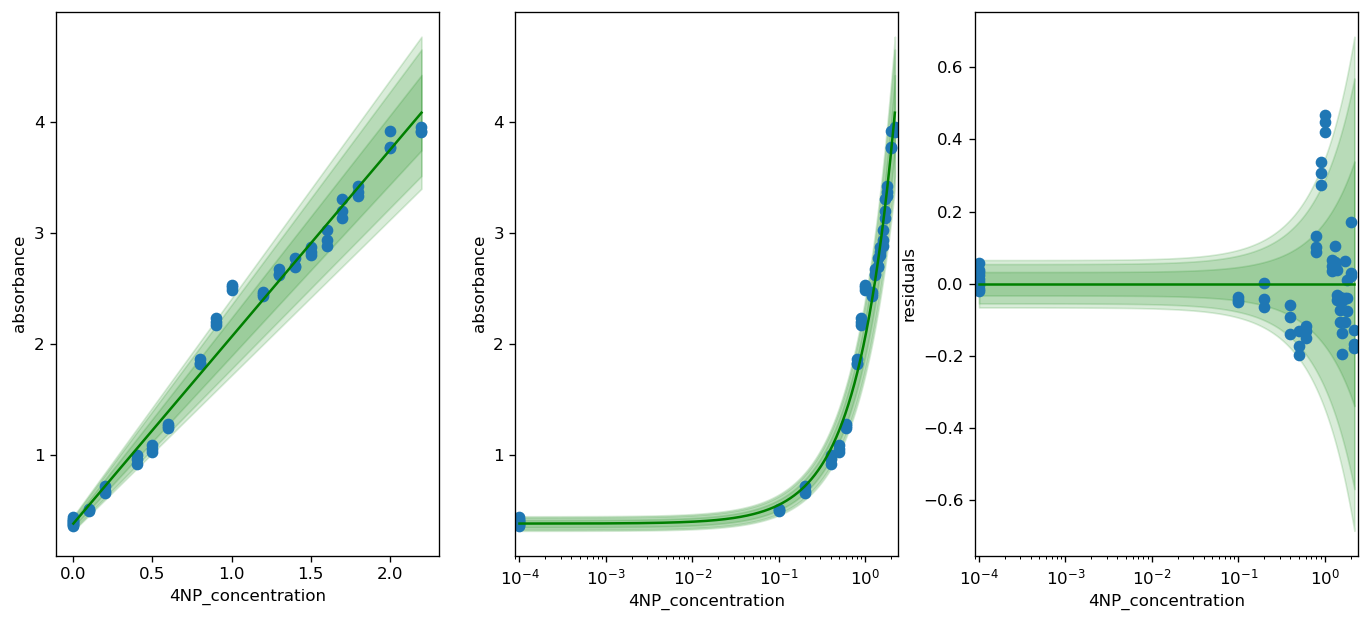

In [5]:
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel.load("9REA8P_cm_nitrophenol.json")
calibr8.plot_model(cm_nitrophenol);

Also the split-GFP dataset should be a single DataFrame. For the split-GFP we'll also use time time-delay between pipetting and measurement to further inform the model.

In [6]:
df_sgfp, t0_delta = run_9REA8P.get_df_sgfp()
df_sgfp.head()

The MTP was pipetted at 2020-11-19 18:43:11+00:00 (0.96 hours before the end of the first measurement).
!! Overriding t0_delta with 0.25 hours !!


,A01,A02,A03,A04,A05,A06,A07,A08,A09,A10,...,H03,H04,H05,H06,H07,H08,H09,H10,H11,H12
time_hours,,,,,,,,,,,,,,,,,,,,,
0.000000,78.0,20.0,5.0,77.0,19.0,5.0,78.0,19.0,5.0,74.0,...,2.0,23.0,5.0,2.0,21.0,5.0,1.0,21.0,5.0,2.0
0.801389,142.0,41.0,8.0,150.0,39.0,8.0,152.0,38.0,9.0,146.0,...,3.0,45.0,10.0,3.0,41.0,9.0,2.0,42.0,9.0,3.0
1.602778,197.0,60.0,13.0,213.0,58.0,13.0,218.0,58.0,13.0,210.0,...,3.0,69.0,16.0,4.0,65.0,14.0,4.0,65.0,15.0,4.0
2.404167,241.0,75.0,15.0,265.0,74.0,16.0,273.0,76.0,16.0,266.0,...,4.0,89.0,19.0,4.0,86.0,18.0,3.0,85.0,18.0,3.0
3.205556,276.0,92.0,21.0,312.0,91.0,21.0,321.0,94.0,21.0,313.0,...,6.0,109.0,26.0,6.0,106.0,24.0,6.0,106.0,24.0,7.0


## Creating the Model
The model is initialized from the `df_inputs` that explains the structure of the dataset, plus the observations from cutinase assay, split-GFP assay or both.

In [22]:
model = cutisplit.CombinedModel(
    df_inputs,
    df_cutinase=df_cutinase,
    cm_nitrophenol=cm_nitrophenol,
    df_sgfp=df_sgfp,
    t0_delta=t0_delta,
)
# the shapes of the dataset are encoded in the "coords" of the underlying PyMC3 model:
model.summary()

type                (1,)	reference
input_well          (48,)	A01, A02, A03, …, H06
assay_well          (96,)	A01, A02, A03, …, H12
cutinase_cycle      (30,)	0, 1, 2, …, 29
sgfp_cycle          (19,)	0, 1, 2, …, 18
assay_column        (12,)	01, 02, 03, …, 12


The PyMC3 model can be visualized as a graph:

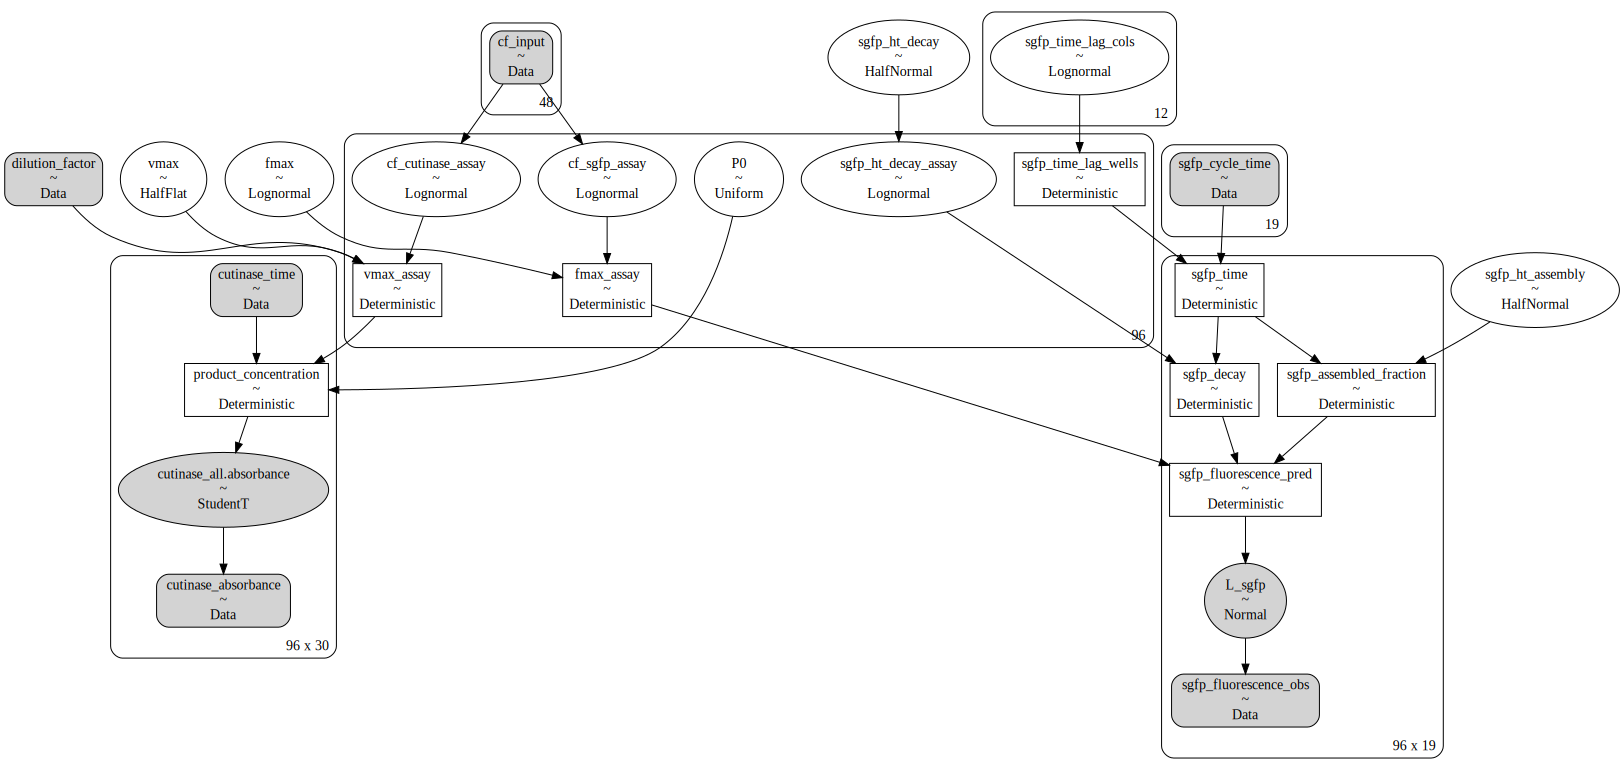

In [23]:
pymc3.model_to_graphviz(model.pmodel)

In [25]:
with model.pmodel:
    idata = pymc3.sample(return_inferencedata=True, target_accept=0.9)
idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sgfp_ht_decay_assay, sgfp_ht_decay, sgfp_ht_assembly, fmax, sgfp_time_lag_cols, P0, vmax, cf_sgfp_assay, cf_cutinase_assay]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 484 seconds.


0, dim: assay_well, 96 =? 96
1, dim: sgfp_cycle, 19 =? 19


The number of effective samples is smaller than 10% for some parameters.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

The result should be saved such that the analysis can run in another notebook.

In [26]:
idata.to_netcdf("9REA8P_result.nc")

'9REA8P_result.nc'